<a href="https://colab.research.google.com/github/s-sridhar24/EVA4-S5/blob/master/Play_EVA4S5F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

# Program Targets:

* Consistent accuracy of 99.4%
* Achieve using less than 10K parameters and in <= 15 epochs
* Share this as 5 steps with obj, analysis for each step

This file contains step 1.
# `Step 1 Objectives: `

*   Create a working version including libraries, input data transformed (normalized) and split of train, test done and a network architecture that can be improved upon in subsequent steps
*   This step does not focus on implementing Best practices 





# Step 1 Output Analysis

The basic code worked fine. Architecture is written in a way that is easy to modify and add other aspects that are required. 

At the end of 15 epochs, following are the results

Overfitting is observed with
Test Accuracy: 98.7-98.8, 
Training: 99.3 -99.4.  

Count of Parameters: 41,364

Improvements needed on Performance and Parameters

Step 2 focus is performnce.

Will implement best pratices BatchNormalization, MaxPooling, GAP as these are anyways needed for performance improvement and design optimization.


Parameters and RF were as calculated using Excel. That is also pasted for quick reference.

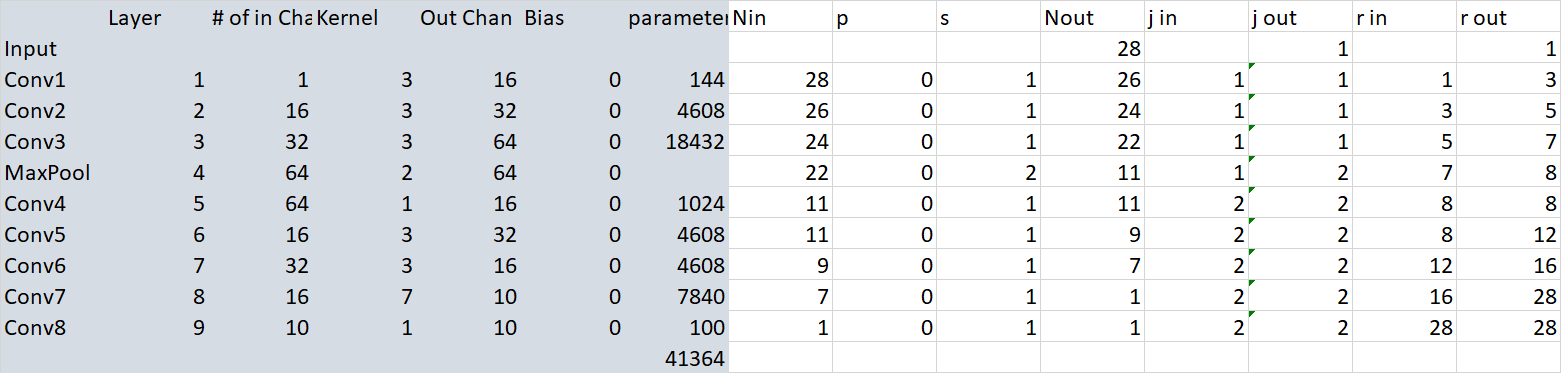

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
# train contains train_data and train_labels
print(train.train_labels.numpy().shape)
print(train.train_data.numpy().shape)
print(test.test_labels.numpy().shape)
print(test.test_data.numpy().shape)

(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Basic exploratory data analysis



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


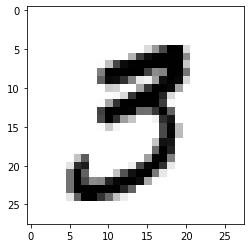

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())


print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')


## View more images
Display the next 100 images to familiarize with the shapes and orientation involved

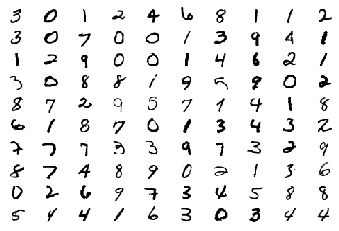

In [0]:
figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# level of brightness and thickness is inconsistent

# shape related observations for each class:
0,5: consistent 
1,3,6,8,9: slight tilts both ways
2: shapes not consistent with a loop at the base sometimes, 
4: two types of shapes one which ends as a triangle at the top and other is open, 
7: two shapes used one without a dash, 


# The model
This is a basic model architecture
This is done in a way extending it will be easy

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) 
        # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24, RF = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22, RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11, RF = 8

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9, RF = 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7, RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 1, RF = 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1, RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           1,024
              ReLU-9           [-1, 16, 11, 11]               0
           Conv2d-10             [-1, 32, 9, 9]           4,608
             ReLU-11             [-1, 32, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           4,608
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17313967645168304 Batch_id=468 Accuracy=62.39: 100%|██████████| 469/469 [00:10<00:00, 42.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1895, Accuracy: 9409/10000 (94.09%)

EPOCH: 1


Loss=0.04114629700779915 Batch_id=468 Accuracy=95.55: 100%|██████████| 469/469 [00:10<00:00, 46.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9733/10000 (97.33%)

EPOCH: 2


Loss=0.054675742983818054 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:10<00:00, 54.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9767/10000 (97.67%)

EPOCH: 3


Loss=0.035052645951509476 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:10<00:00, 45.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9832/10000 (98.32%)

EPOCH: 4


Loss=0.1401672214269638 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:10<00:00, 43.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


Loss=0.06959649920463562 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:11<00:00, 40.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9854/10000 (98.54%)

EPOCH: 6


Loss=0.03137735649943352 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:10<00:00, 45.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9874/10000 (98.74%)

EPOCH: 7


Loss=0.003284777281805873 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 45.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9862/10000 (98.62%)

EPOCH: 8


Loss=0.08665543794631958 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 46.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9875/10000 (98.75%)

EPOCH: 9


Loss=0.022844046354293823 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:10<00:00, 43.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9876/10000 (98.76%)

EPOCH: 10


Loss=0.013193413615226746 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 42.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9875/10000 (98.75%)

EPOCH: 11


Loss=0.042585890740156174 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9886/10000 (98.86%)

EPOCH: 12


Loss=0.04201405122876167 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9874/10000 (98.74%)

EPOCH: 13


Loss=0.005786076188087463 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:10<00:00, 42.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9888/10000 (98.88%)

EPOCH: 14


Loss=0.0027319390792399645 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.053530942648649216 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:11<00:00, 41.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9880/10000 (98.80%)

EPOCH: 16


Loss=0.03776560351252556 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:10<00:00, 54.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9888/10000 (98.88%)

EPOCH: 17


Loss=0.009694288484752178 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:10<00:00, 43.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9894/10000 (98.94%)

EPOCH: 18


Loss=0.006235996726900339 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 44.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9895/10000 (98.95%)

EPOCH: 19


Loss=0.0018114844569936395 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]



Test set: Average loss: 0.0406, Accuracy: 9892/10000 (98.92%)



Text(0.5, 1.0, 'Test Accuracy')

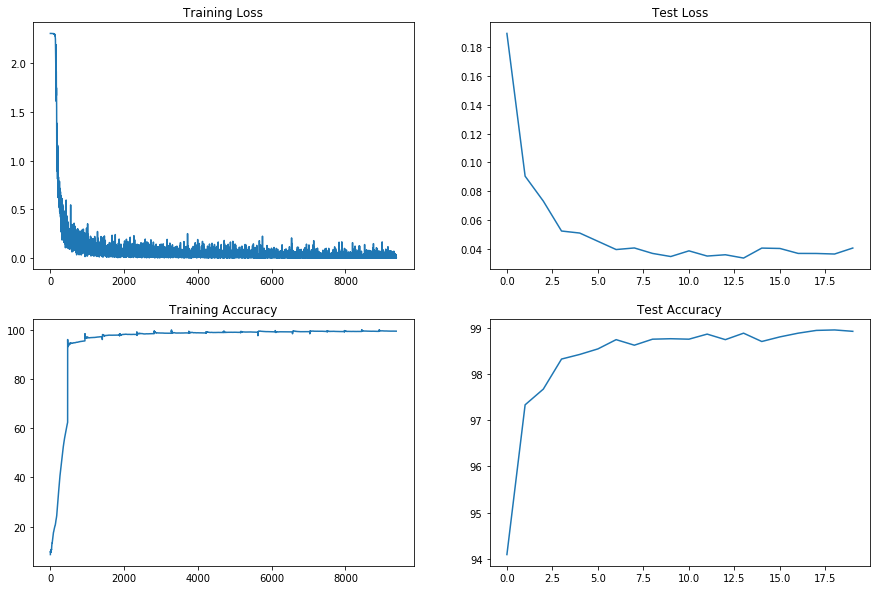

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")